## Runge-Kutta Method

Armed with Taylor expansion, we can easily get 4th-order Runge-Kutta method by
truncating to first four terms. Typically we choose coefficients like:

$$y(x_0+h) = y(x_0)+\frac{h}{6}(f_0+2f_2+2f_2+f_3)$$

where:

$$\begin{matrix}
f_0 &= &f(x_0, y_0) \\
f_1 &= &f(x_0+h/2, y_0+hf_0/2) \\
f_2 &= &f(x_0+h/2, y_0+hf_1/2) \\
f_3 &= &f(x_0+h, y_0+hf_2)
\end{matrix}$$

### Example:

This time let's consider the famous Lorenz equations, i.e.

$$\begin{matrix}
\frac{dx}{dt} &= &\sigma(y-x) \\
\frac{dy}{dt} &= &rx-y-xz \\
\frac{dz}{dt} &= &xy-bz
\end{matrix}$$

We can define two vector:

$$\vec{y}=\big(\begin{matrix}x\\y\\z\end{matrix}\big)$$

and

$$\vec{f}=\big(\begin{matrix}\sigma(y-x)\\rx-y-xz\\xy-bz\end{matrix}\big)$$

Threrfore, $\vec{y}\prime=\vec{f}$.

We consider zhe case $\sigma=10, r=28, b=8/3$ and initial condition $\vec{y}=(0,1,0)$

### Code Example (Julia language):

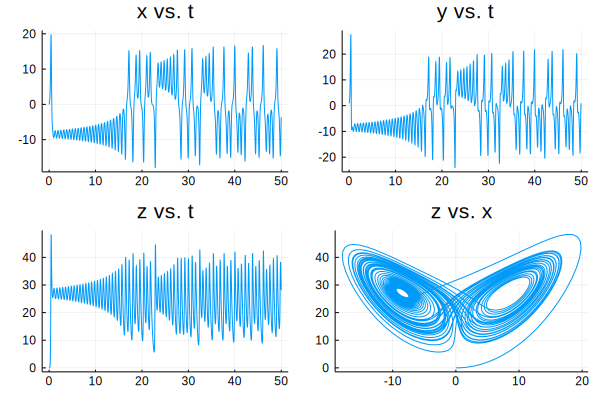

In [8]:
using Plots

function func(y::Array{Float64})
    σ = 10.0
    r = 28.0
    b = 8.0/3
    vector_f = similar(y)
    
    vector_f[1] = σ*(y[2]-y[1])
    vector_f[2] = r*y[1]-y[2]-y[1]*y[3]
    vector_f[3] = y[1]*y[2]-b*y[3]
    return vector_f
end

function Runge_Kutta(f::Function, h::Float64, y₀::Array{Float64})
    t = [i for i in 0.0:h:50.0]
    y = Array{Float64}(undef, 3, size(t)[1])
    y[:, 1] = y₀
    
    for i in 1:(size(t)[1]-1)
        f₀ = f(y[:, i])
        f₁ = f(y[:, i]+f₀*h/2)
        f₂ = f(y[:, i]+f₁*h/2)
        f₃ = f(y[:, i]+f₂*h)
        
        y[:, i+1] = y[:, i]+h*(f₀+2*f₁+2*f₂+f₃)./6
    end
    
    plot(
        plot(t, y[1, :], title="x vs. t", layout=1),
        plot(t, y[2, :], title="y vs. t"),
        plot(t, y[3, :], title="z vs. t"),
        plot(y[1, :], y[3, :], title="z vs. x"),
        leg=false
    )
end

y₀ = [0.0; 1.0; 0.0]
Runge_Kutta(func, 0.01, y₀)

Beautiful, isn't it? That's the famous Lorenz attractor.

## Runge-Kutta-Fehlberg Method

For some function, there could exist large derivative while derivative is small in other place. Therefore, the error term is large in some place, while small in other 
place. So, it's necessary to modify interval h automatically. That's when you need Runge-Kutta-Fehlberg method.

We define the coefficients of fourth-order Runge-Kutta method and fifth-order Runge-Kutta method as:

$$y^{(4)}=y_0+h(\frac{25}{216}f_0+\frac{1408}{2565}f_2+\frac{2197}{4104}f_3-\frac{1}{5}f_4)$$

$$y^{(5)}=y_0+h(\frac{16}{135}f_0+\frac{6656}{12825}f_2+\frac{28561}{56430}f_3-\frac{9}{50}f_4+\frac{2}{55}f_5)$$

where:

$$\begin{matrix}
f_0 &= &f(x_0, y_0) \\
f_1 &= &f(x_0+h/4, y_0+hf_0/4) \\
f_2 &= &f(x_0+3h/8, y_0+3hf_0/32+9hf_1/32) \\
f_3 &= &f(x_0+12h/13, y_0+1932hf_0/2197-7200hf_1/2197-7296hf_2/2197) \\
f_4 &= &f(x_0+h, y_0+439hf_0/216-8hf_1+3680hf_2/513-845hf_3/4104) \\
f_5 &= &f(x_0+h/2, y_0-8hf_0/27+2hf_1-3544hf_2/2565+1859hf_3/4104-11hf_4/40)
\end{matrix}$$

Then we can calculate the new interval h given tolerance $\epsilon$ and original interval h, i.e.

$$h_{new} = 0.9h\sqrt[4]{\frac{h\epsilon}{\big|y^{(4)}-y^{(5)}\big|}}$$

If the new h is larger than original h, we accept the step. If not, we use the new h as h to calculate another new h and compare it with the original h.

### Example

Let's solve a simple quantum mechanics problem. Consider an electron bound in the anhrmonic potential, i.e. $V(x)=\alpha x^2+\beta x^4$.

The Schrodinger equation is writen as $\frac{\partial^2\psi}{\partial x^2}=-\frac{2m}{\hbar}(E-V)\psi$

We define $\alpha = 0.5$, $\beta=0.25$. And we plan to find its firs states.

In [1]:
function func(y::Array{Float64}, x::Float64)
    α = 0.5
    β = 0.25
    m = 1
    ħ = 2.76
    vector_f = similar(y)
    
    vector_f[1] = y[2]
    vector_f[2] = -2*m/ħ*(E-(α+β*x^2)*x^2)*y[1]
    return vector_f
end

function Fehlberg(f::Function, y₀::Array{Float64}, ϵ::Float64, h₀::Float64)
    x = [-5.0,]
    y = [y₀,]
    i = 1
    
    while x[i] <= 0.0
        h = h₀
        while true
            f₀ = f(y[i], x[i])
            f₁ = f(y[i]+f₀*h/4, x[i]+h/4)
            f₂ = f(y[i]+f₀*3*h/32+f₁*9*h/32, x[i]+3*h/8)
            f₃ = f(y[i]+1932*h*f₀/2197-7200*h*f₁/2197+7296*h*f₂/2197, x[i]+12*h/13)
            f₄ = f(y[i]+439*h*f₀/216-8*h*f₁+3680*h*f₂/513-845*h*f₃/4104, x[i]+h)
            f₅ = f(y[i]-8*h*f₀/27+2*h*f₁-3544*h*f₂/2565+1859*h*f₃/4104-11*h*f₄/40, x[i]+h/2)
            
            y⁴ = y[i] + h*(25*f₀/216 + 1408*f₂/2565 + 2197*f₃/4104 - f₄/5)
            y⁵ = y[i] + h*(16*f₀/135 + 6656*f₂/12825 + 28561*f₃/56430 - 9*f₄/50 + 2*f₅/55)
            h_new = 0.9*h*sqrt(ϵ*h/abs(y⁴[1]-y⁵[1]))
            if(h_new >= h)
                push!(x, x[i]+h)
                push!(y, y⁵)
                break
            else
                h = h_new
            end
        end
        i += 1
    end
    
    return x, y
end

δ = 1e-2
E = 1.0
for i in 1:100
    x, y = Fehlberg(func, [0.0; 1e-7], 1e-5, 1e-5)
    if abs(y[end][1])<δ || abs(y[end][2])<δ
        print("\nEnergy: ")
        println(E)
        break
    end
    
    E += 0.01
end


Energy: 1.12
